In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
config.update('jax_enable_x64', True)
import jax, numpyro
numpyro.set_host_device_count(4)
print ('# jax device count:', jax.local_device_count())

# jax device count: 4


In [3]:
d = pd.read_csv("v1298tau/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(4)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(4)]
p_init = [8.2438, 12.3960, 24.1315, 24.1315*2]

### set transit time errors for inner two planets to be 0.01d

In [4]:
errorobs[0] = jnp.ones_like(errorobs[0])*0.01
errorobs[1] = jnp.ones_like(errorobs[1])*0.01

In [5]:
print (np.min(d.tc), np.max(d.tc))

2231.283312 4689.396172


In [6]:
dt = 0.2
t_start, t_end = 2230., 4700.
jttv = jaxttv(t_start, t_end, dt)

In [7]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           2230.00
# first transit time in data:      2231.28
# last transit time in data:       4689.40
# integration ends at:             4700.00
# integration time step:           0.2000 (1/41 of innermost period)


In [8]:
base = "v1298tau/dt0p2_errorrev_lin_"

initial objective function: 211962912.58 (46 data)

running LM optimization...
objective function: 37.97 (46 data)
# elapsed time (least square): 61.7 sec


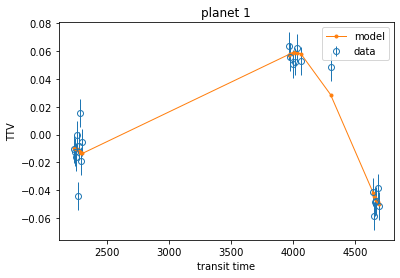

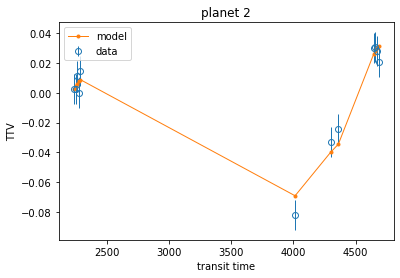

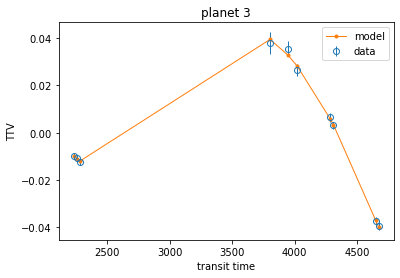

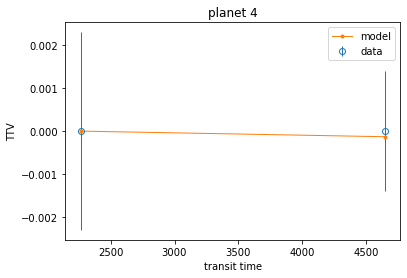

In [9]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)#, save=base+"ql")

In [10]:
tc, de = jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))
print (de)

-5.799914682080853e-06


In [11]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

39.7 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass     period     ecosw     esinw  cosi  lnode          tic  \
0  0.252443   8.248621  0.109272  0.049172  -0.0    0.0  2231.284096   
1  0.372781  12.402707  0.001272  0.000891  -0.0   -0.0  2239.392487   
2  3.812245  24.139631 -0.003093  0.041413  -0.0    0.0  2234.049500   
3  2.727671  48.677670  0.034852 -0.017807  -0.0    0.0  2263.623352   

        ecc     omega     lnmass          mass      cosw      sinw  
0  0.119825  0.422849 -14.092307  7.582088e-07  0.911924  0.410360  
1  0.001553  0.611301 -13.702501  1.119643e-06  0.127199  0.089148  
2  0.041529  1.645336 -11.377518  1.145004e-05 -0.074471  0.997223  
3  0.039137 -0.472356 -11.712288  8.192530e-06  0.890499 -0.454985  


In [13]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(p_init)
ones = jnp.ones_like(p_guess)

In [14]:
from numpyro.infer import init_to_value
import numpyro
import numpyro.distributions as dist
import jax.random as random

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    #cosO = numpyro.sample("cosO", dist.Normal(scale=jnp.array([1, 1])))
    #sinO = numpyro.sample("sinO", dist.Normal(scale=jnp.array([1, 1])))
    #lnode = jnp.arctan2(sinO, cosO)
    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    #tcmodel, ediff = jttv.get_ttvs_hermite4(elements, jnp.hstack([1, mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    #tcmodel = jnp.nan_to_num(tcmodel, nan=-jnp.inf)
    #ediff = jnp.nan_to_num(ediff, nan=jnp.inf)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=jttv.errorobs_flatten), obs=jttv.tcobs_flatten)

In [15]:
init_strategy = init_to_value(values=pdic_init)
pdic_init

{'period': DeviceArray([ 8.24862134, 12.40270653, 24.13963123, 48.67767008], dtype=float64),
 'cosi': DeviceArray([-0., -0., -0., -0.], dtype=float64),
 'lnode': DeviceArray([ 0., -0.,  0.,  0.], dtype=float64),
 'tic': DeviceArray([2231.28409632, 2239.39248689, 2234.04950027, 2263.62335178],            dtype=float64),
 'ecc': DeviceArray([0.11982532, 0.00155329, 0.04152878, 0.03913735], dtype=float64),
 'lnmass': DeviceArray([-14.09230708, -13.70250089, -11.37751768, -11.71228783], dtype=float64),
 'mass': DeviceArray([7.58208760e-07, 1.11964275e-06, 1.14500361e-05,
              8.19252967e-06], dtype=float64),
 'cosw': DeviceArray([ 0.91192356,  0.12719887, -0.07447056,  0.89049892], dtype=float64),
 'sinw': DeviceArray([ 0.4103601 ,  0.08914814,  0.99722321, -0.45498536], dtype=float64)}

In [16]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.8, init_strategy=init_strategy)

In [17]:
nw, ns = 250, 1000 # acc=0.8, 62hr for 4 chains in parallel

In [18]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=4, progress_bar=False)

In [25]:
import os, dill
posterior = base+"mcmc.pkl"
if os.path.exists(posterior):
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, extra_fields=('potential_energy',), mmin=0, mmax=1e-4, uniform_mass=True)
    with open(base+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

In [26]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]      0.22      0.77      0.18     -0.95      1.57    136.23      1.03
   cosw[1]     -0.19      0.69     -0.18     -1.33      0.99    125.56      1.03
   cosw[2]      0.03      0.55      0.04     -0.84      1.05     68.99      1.03
   cosw[3]      0.06      0.62      0.05     -0.96      1.05     61.75      1.09
    ecc[0]      0.07      0.08      0.04      0.00      0.20     27.80      1.19
    ecc[1]      0.06      0.08      0.03      0.00      0.17     28.93      1.13
    ecc[2]      0.05      0.06      0.03      0.00      0.13     49.48      1.13
    ecc[3]      0.06      0.06      0.03      0.00      0.14     26.58      1.13
   mass[0]      0.00      0.00      0.00      0.00      0.00     20.46      1.18
   mass[1]      0.00      0.00      0.00      0.00      0.00     21.09      1.17
   mass[2]      0.00      0.00      0.00      0.00      0.00     15.76      1.22
   mass[3]      0.00      0

In [28]:
samples = mcmc.get_samples()

In [33]:
idx = samples['ediff']==samples['ediff']
np.sum(~idx)

0

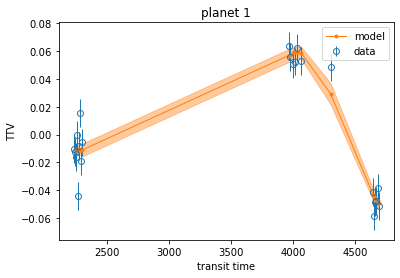

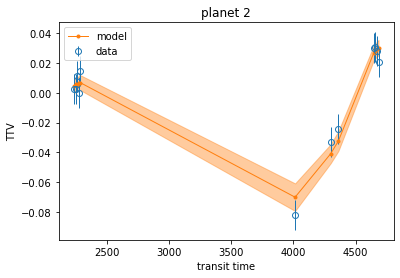

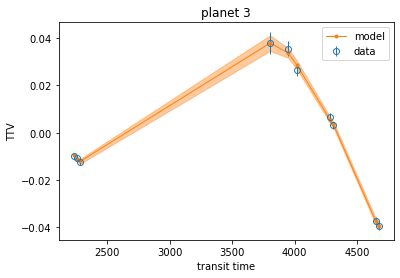

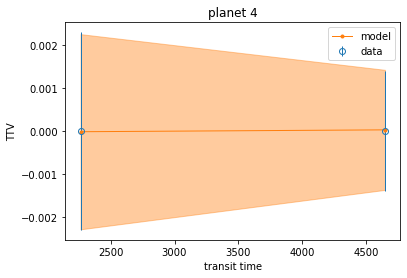

In [32]:
mmodel, smodel = jnp.mean(samples['tcmodel'], axis=0), jnp.std(samples['tcmodel'], axis=0)
jttv.quicklook(mmodel, sigma=smodel)#, save=base+"postm")

0.0114154324954613 1.14154324954613 0.01 0.01
0.0067304521409696305 0.6730452140969629 0.01 0.01
0.0009779025070833938 0.09779025070833938 0.00171 0.004524
2.1648946130881086e-05 0.0021648946130881086 0.00185 0.0023


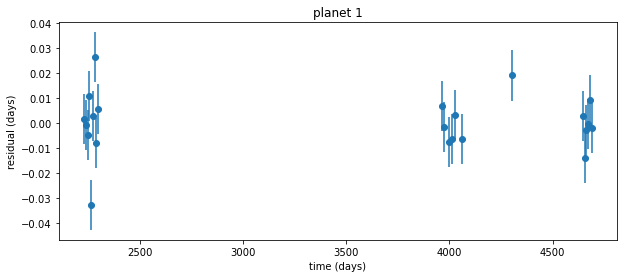

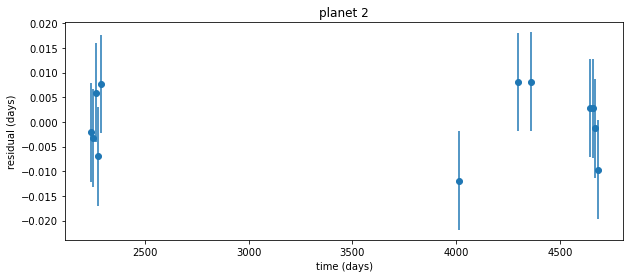

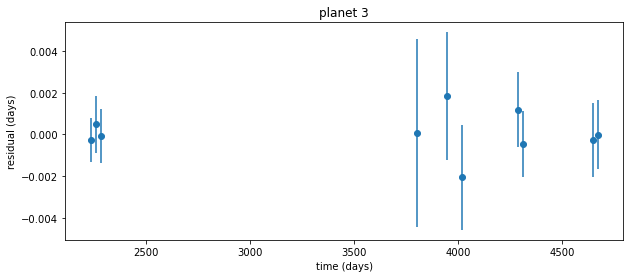

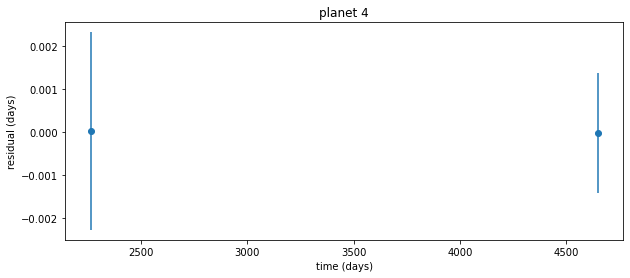

In [36]:
for j in range(4):
    plt.figure(figsize=(10,4))
    _idx = jttv.pidx==j+1
    res = jttv.tcobs_flatten[_idx]-mmodel[_idx]
    print (np.std(res), np.std(res/0.01), np.median(jttv.errorobs_flatten[_idx]), np.max(jttv.errorobs_flatten[_idx]))
    #plt.errorbar(jttv.tcobs_flatten[_idx], res/jttv.errorobs_flatten[_idx], fmt='o')
    plt.errorbar(jttv.tcobs_flatten[_idx], res, yerr=jttv.errorobs_flatten[_idx], fmt='o')
    plt.title("planet %d"%(j+1))
    plt.xlabel("time (days)")
    plt.ylabel('residual (days)')

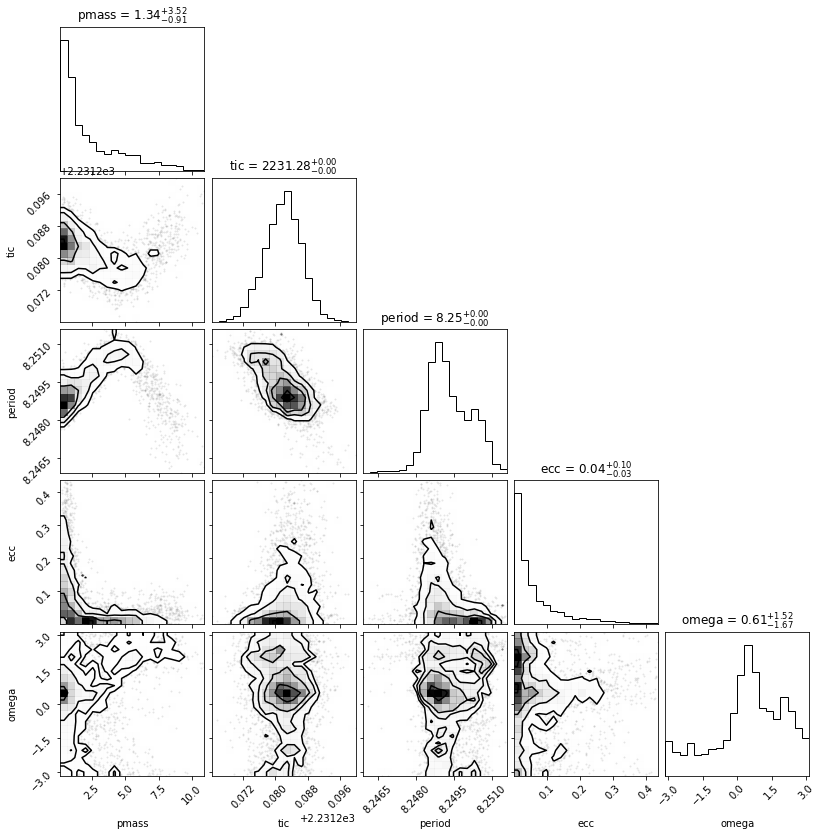

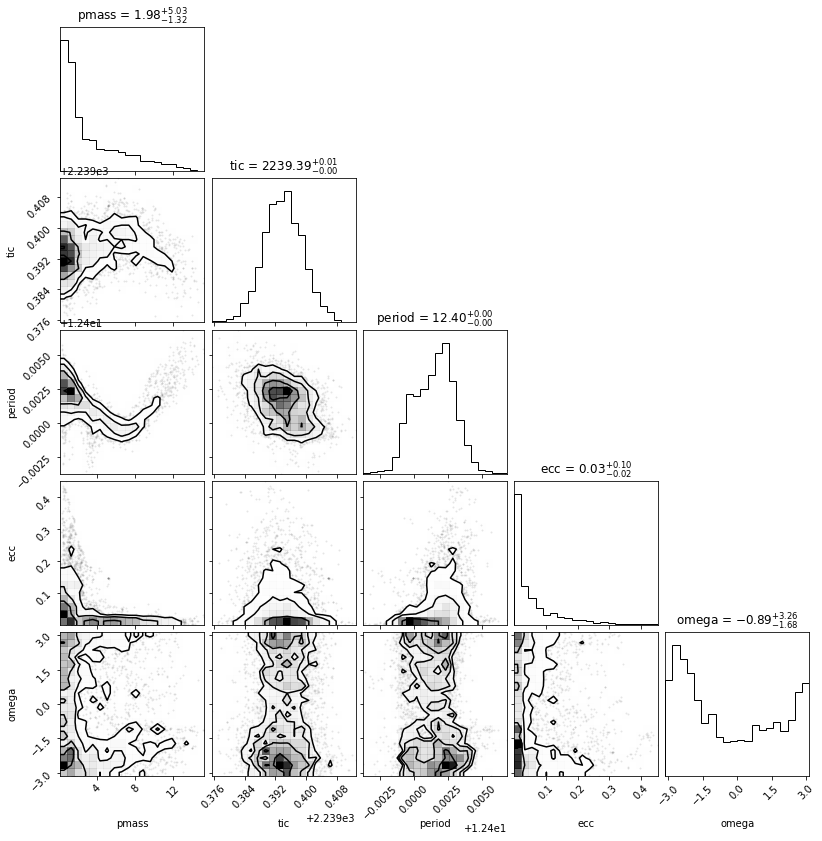

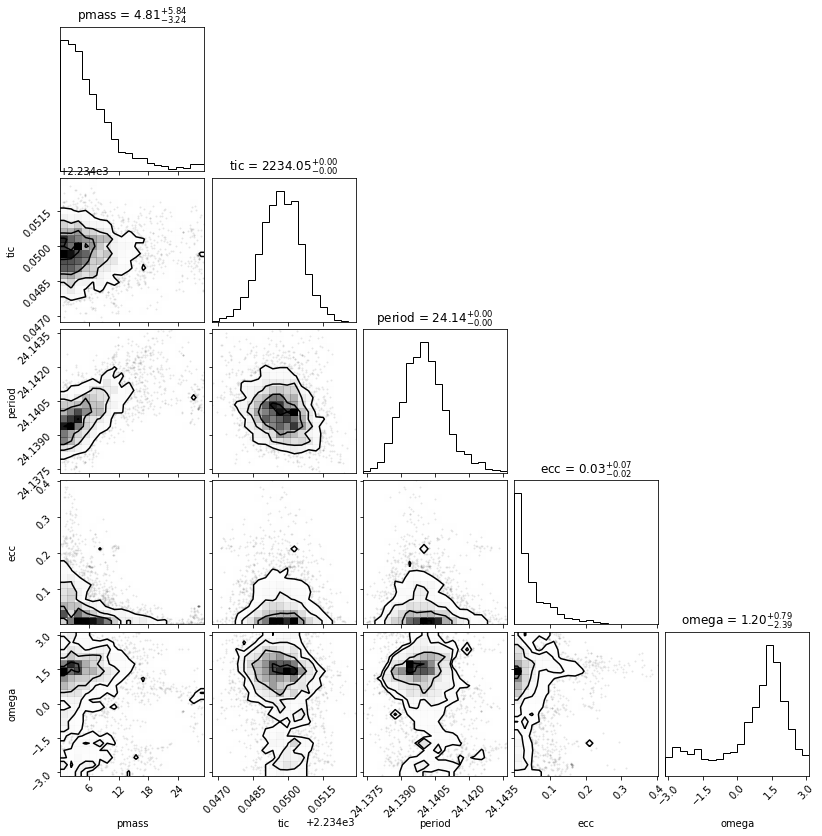

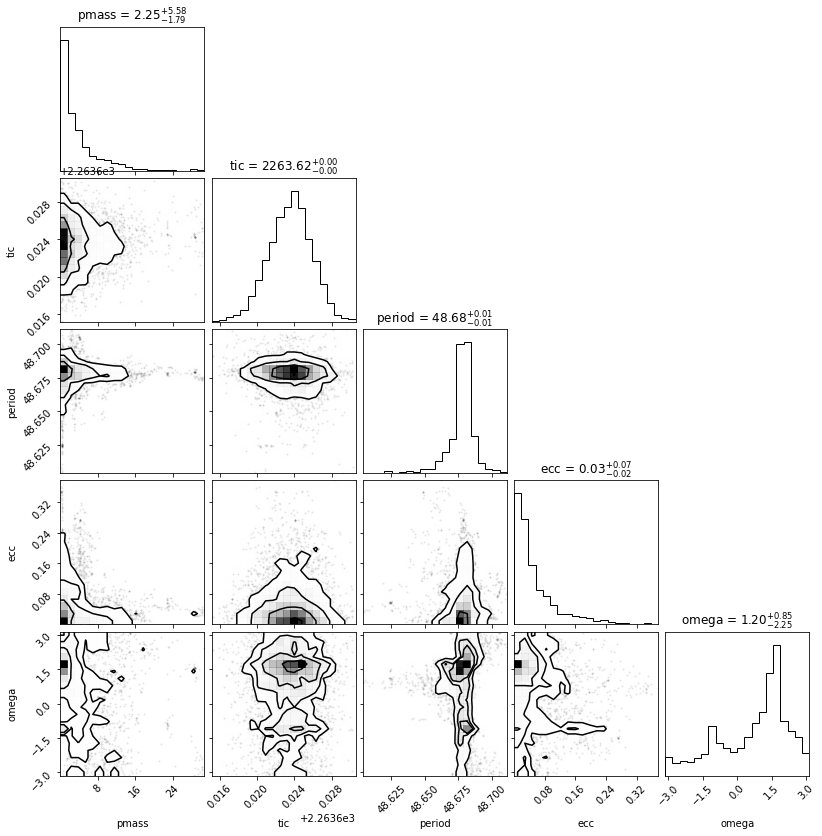

In [37]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']
#keys = ['lnmass', 'tic', 'period', 'ecc', 'omega']

for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles="%.2f")
    #plt.savefig(base+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight")

In [39]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           2230.00
# first transit time in data:      2231.28
# last transit time in data:       4689.40
# integration ends at:             4700.00
# integration time step:           0.0200 (1/412 of innermost period)


In [40]:
k = 100

In [41]:
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))

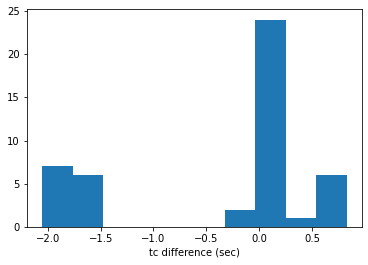

In [43]:
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.);